In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage import gaussian_filter
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [ ]:
# !pip install datasets

# Mounting to GOOGLE DRIVE

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading Images and Target Names

In [ ]:

train_directory = '/content/gdrive/MyDrive/Alzheimer_s_Dataset/train'
test_directory = '/content/gdrive/MyDrive/Alzheimer_s_Dataset/test'
filepaths = []
labels = []

folds = os.listdir(train_directory)
for fold in folds:
    foldpath = os.path.join(train_directory, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)




In [ ]:
filepaths = []
labels = []

folds = os.listdir(test_directory)
for fold in folds:
    foldpath = os.path.join(test_directory, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

# Displaying Images

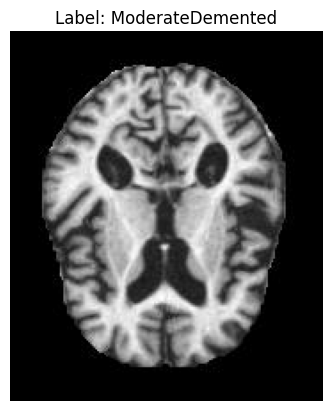

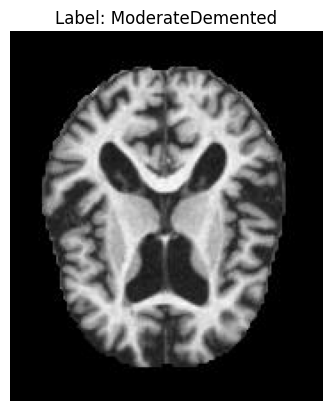

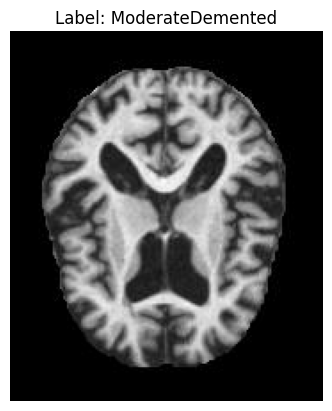

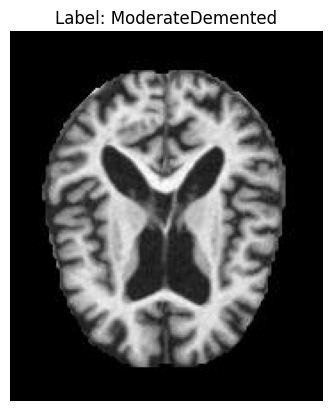

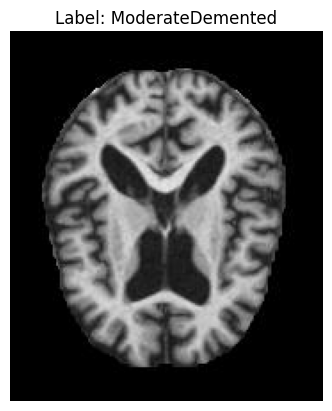

In [ ]:
num_images_to_display = 5
for i in range(num_images_to_display):
    image_path = train_df['filepaths'].iloc[i]
    label = train_df['labels'].iloc[i]

    # Read and display the image using OpenCV
    image = cv2.imread(image_path)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Count of Classes

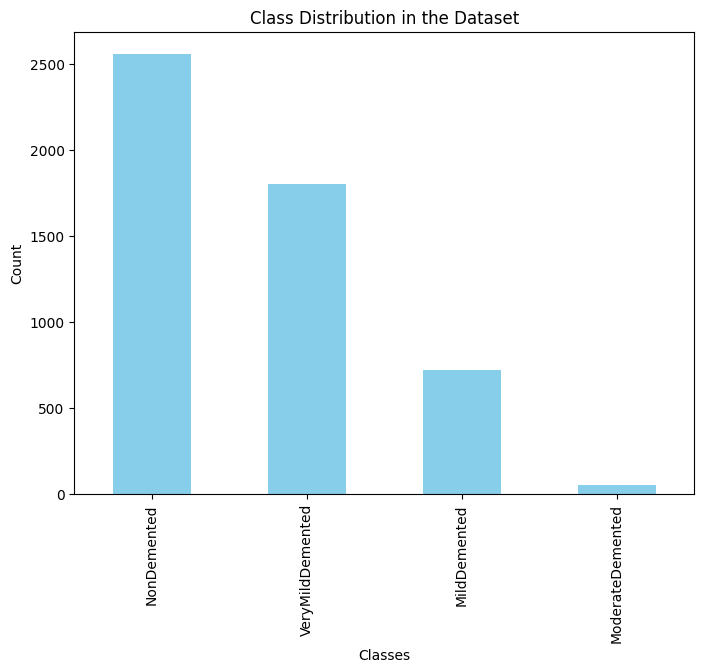

Class Names: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
Class Counts: [2560, 1802, 717, 52]


In [ ]:
# Calculate the frequency of each class
class_count = train_df['labels'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
class_count.plot(kind='bar', color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in the Dataset')
plt.show()

print("Class Names:", class_count.index.tolist())
print("Class Counts:", class_count.tolist())

# Image Augmentation and Train_test_split

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
# Apply image augmentation to training data
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Apply rescaling (no augmentation) to validation data
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5131 validated image filenames belonging to 4 classes.
Found 767 validated image filenames belonging to 4 classes.


# Model Architectures

## 1.EfficientNetB0

In [ ]:
# Define the model
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys()))

# (EfficientNetB0 in this case)
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build your model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
batch_size = 32
# Display the model architecture
model.summary()
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [ ]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Accuracy:", test_results[1])
print("Test Loss:", test_results[0])

from sklearn.metrics import classification_report

# Generate predictions for the test set
test_predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(test_predictions, axis=1)

# Get true class labels from the test generator
true_classes = test_generator.classes

# Get class labels (assuming 'class_mode' is 'categorical')
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [ ]:
# Confusion Matrix
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 2.CNN (Without Padding and Augmentation)

In [ ]:
# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

batch_size = 32
epochs = 20
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)

## 3.CNN (with Data Augmentation)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

# Specify batch size
batch_size = 32
epochs = 20

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs
)
